In [22]:
# few packages to import
import sympy as sy
import numpy as np
from ipywidgets import interactive
from sympy import init_session
init_session() 
la=np.linalg
%config IPCompleter.greedy=True
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # retina display

IPython console for SymPy 1.11.1 (Python 3.9.12-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.11.1/



## Design an insertion
We will now solve the problem of trasporting given initial optical condition to a target optical function.
Typically we want to transport ($\beta_x$,$\alpha_x$, $\beta_y$, $\alpha_y$) to ($\beta_0$, $0$, $\beta_0$, $0$) (i.e. a $\beta$-waist with round optics).
An initial approach to this problem is to start solving a FODO with initial condition. So we ask ourself: if a enter a FODO with ($\beta_0$, $0$, $\beta_0$, $0$) what are the final solution of the $\beta$-functions?

We have to remember the transport equation
\begin{equation}
\underbrace{{\begin{pmatrix}
\beta(s_1)  &        -\alpha(s_1) \\
-\alpha(s_1)  & \gamma(s_1) 
\end{pmatrix}}}_{J(s_1)\ \Omega^{-1}}
 = M  
\underbrace{{\begin{pmatrix}
\beta(s_0)  &        -\alpha(s_0)\\
-\alpha(s_0) & \gamma(s_0)
\end{pmatrix}}}_{J(s_0)\ \Omega^{-1}}
\ M^T.
\label{eq:standardPropagation}
\end{equation}


In [23]:
L=sy.Symbol('L', positive=True, real=True);
f=sy.Symbol('f', positive=True, real=True);

b=sy.Symbol('b', positive=True, real=True);
a=sy.Symbol('a', real=True);
c=sy.Symbol('c', positive=True, real=True);


DRIFT=sy.Matrix([[1,L/2], [0,1]])

Q1=sy.Matrix([[1,0], [-1/f,1]])
Q2=sy.Matrix([[1,0], [1/f,1]])


Mlr=Q2@DRIFT@Q1@DRIFT
Mlr=sy.simplify(Mlr)
sigma0=sy.Matrix([[b,0], [0,1/b]])
sigma1=sy.simplify(Mlr@sigma0@Mlr.transpose())
sigma1

⎡           2          2      2          2               ⎛   2                       ⎛   2              2⎞⎞⎤
⎢          L ⋅(L - 4⋅f)  + 4⋅b ⋅(L - 2⋅f)              L⋅⎝4⋅b ⋅(L - 2⋅f) - (L - 4⋅f)⋅⎝- L  + 2⋅L⋅f + 4⋅f ⎠⎠⎥
⎢          ───────────────────────────────             ────────────────────────────────────────────────────⎥
⎢                            2                                                     3                       ⎥
⎢                      16⋅b⋅f                                                16⋅b⋅f                        ⎥
⎢                                                                                                          ⎥
⎢                                                                                               2          ⎥
⎢  ⎛   2                       ⎛   2              2⎞⎞               2  2   ⎛   2              2⎞           ⎥
⎢L⋅⎝4⋅b ⋅(L - 2⋅f) - (L - 4⋅f)⋅⎝- L  + 2⋅L⋅f + 4⋅f ⎠⎠            4⋅L ⋅b  + ⎝- L  + 2⋅L⋅f + 4⋅f ⎠           ⎥
⎢──────────────────

A very useful property is that we can reach the ($\beta_0$, $0$, $\beta_0$, $0$) starting from the just found solution (**BUT** inverting $\alpha$) using a  **symmetric configuration**. In other words:

In [3]:
# PAY ATTENTION TO THE '-'
sigma1_inv=sy.Matrix([[sigma1[0],-sigma1[1]], [-sigma1[2],sigma1[3]]])

Mrl=DRIFT@Q1@DRIFT@Q2

sy.simplify(Mrl@sigma1_inv@Mrl.transpose())

⎡b  0⎤
⎢    ⎥
⎢   1⎥
⎢0  ─⎥
⎣   b⎦

In [24]:
from cpymad.madx import Madx
import matplotlib.patches as patches
from ipywidgets import interactive
def plotLatticeSeries(ax,series, height=1., v_offset=0., color='r',alpha=0.5):
    aux=series
    ax.add_patch(
    patches.Rectangle(
        (aux.s-aux.l, v_offset-height/2.),   # (x,y)
        aux.l,          # width
        height,          # height
        color=color, alpha=alpha
    )
    )
    return;

### Starting from a "modified" FODO: a doublet

In [25]:
myMad = Madx(stdout=False)
f=50
l_quad=1
dipole_angle=0
def f(f, l_quad, beta0):
    myString='''
    ! *********************************************************************
    ! Definition of parameters
    ! *********************************************************************
    option, rbarc=false;
    l_cell=40;
    quadrupoleLenght='''+format(l_quad) +''';
    f='''+format(f) +''';
    myK:=1/f/quadrupoleLenght;// m^-2
    
    ! *********************************************************************
    ! Definition of magnet
    ! ********************************************************************* 
    QF: quadrupole, L:=quadrupoleLenght, K1:=myK;
    QD: quadrupole, L:=quadrupoleLenght, K1:=-myK;


    ! *********************************************************************
    ! Definition of sequence
    ! *********************************************************************
    myHalfSS:sequence, refer=centre, L:=l_cell;
    m1: marker, at=1;
    m2: marker, at=2;
    m3: marker, at=3;
    m4: marker, at=4;
    m5: marker, at=5;
    m6: marker, at=6;
    m7: marker, at=7;
    m8: marker, at=8;
    m9: marker, at=9;
    m10: marker, at=10;
    m11: marker, at=11;
    m12: marker, at=12;
    m13: marker, at=13;
    m14: marker, at=14;
    m15: marker, at=15;
    quadrupole1: QF, at=l_cell/2;
    quadrupole2: QD, at=l_cell/4*3;
    endsequence;

    ! *********************************************************************
    ! Definition of beam
    ! *********************************************************************
    beam;

    ! *********************************************************************
    ! Use of the sequence
    ! *********************************************************************
    use, sequence=myHalfSS;

    ! *********************************************************************
    ! TWISS
    ! *********************************************************************
    twiss, betx='''+format(beta0) +''',bety='''+format(beta0) +''';
    '''
    myMad.input(myString);

    myTwiss=myMad.table.twiss.dframe()

    # plotting the results
    fig = plt.figure(figsize=(13,8))
    # set up subplot grid
    #gridspec.GridSpec(3,3)

    ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
    plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


    DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')


    color = 'red'
    ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
    ax1.tick_params(axis='y', labelcolor=color)
    plt.grid()
    plt.ylim(-.04,.04)
    plt.title('Half study')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'blue'
    ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=color)


    #DF=myTwiss[(myTwiss['keyword']=='sbend')]
    #for i in range(len(DF)):
    #    aux=DF.iloc[i]
    #    plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle*1000/2, color='b')

    DF=myTwiss[(myTwiss['keyword']=='sbend')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.angle, v_offset=aux.angle/2, color='b')
    
    DF=myTwiss[(myTwiss['keyword']=='rbend')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.angle, v_offset=aux.angle/2, color='m')


    plt.ylim(-.11,.11)

    # large subplot
    plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

    plt.plot(myTwiss['s'],myTwiss['betx'],'b.-', label='$\\beta_x$')
    plt.plot(myTwiss['s'],myTwiss['bety'],'r.-', label='$\\beta_y$')
    plt.legend(loc='best')
    plt.ylabel('[m]')
    plt.xlabel('s [m]')
    plt.grid()
    plt.ylim(0,2200)

    ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
    plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$')
    ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
    ax3.tick_params(axis='y', labelcolor='brown')
    
    
interactive_plot = interactive(f, f=(10, 100, 1), l_quad=(0.1 ,10,.1),beta0=(1,2,.01),continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '550px'
interactive_plot

interactive(children=(IntSlider(value=55, description='f', min=10), FloatSlider(value=5.0, description='l_quad…

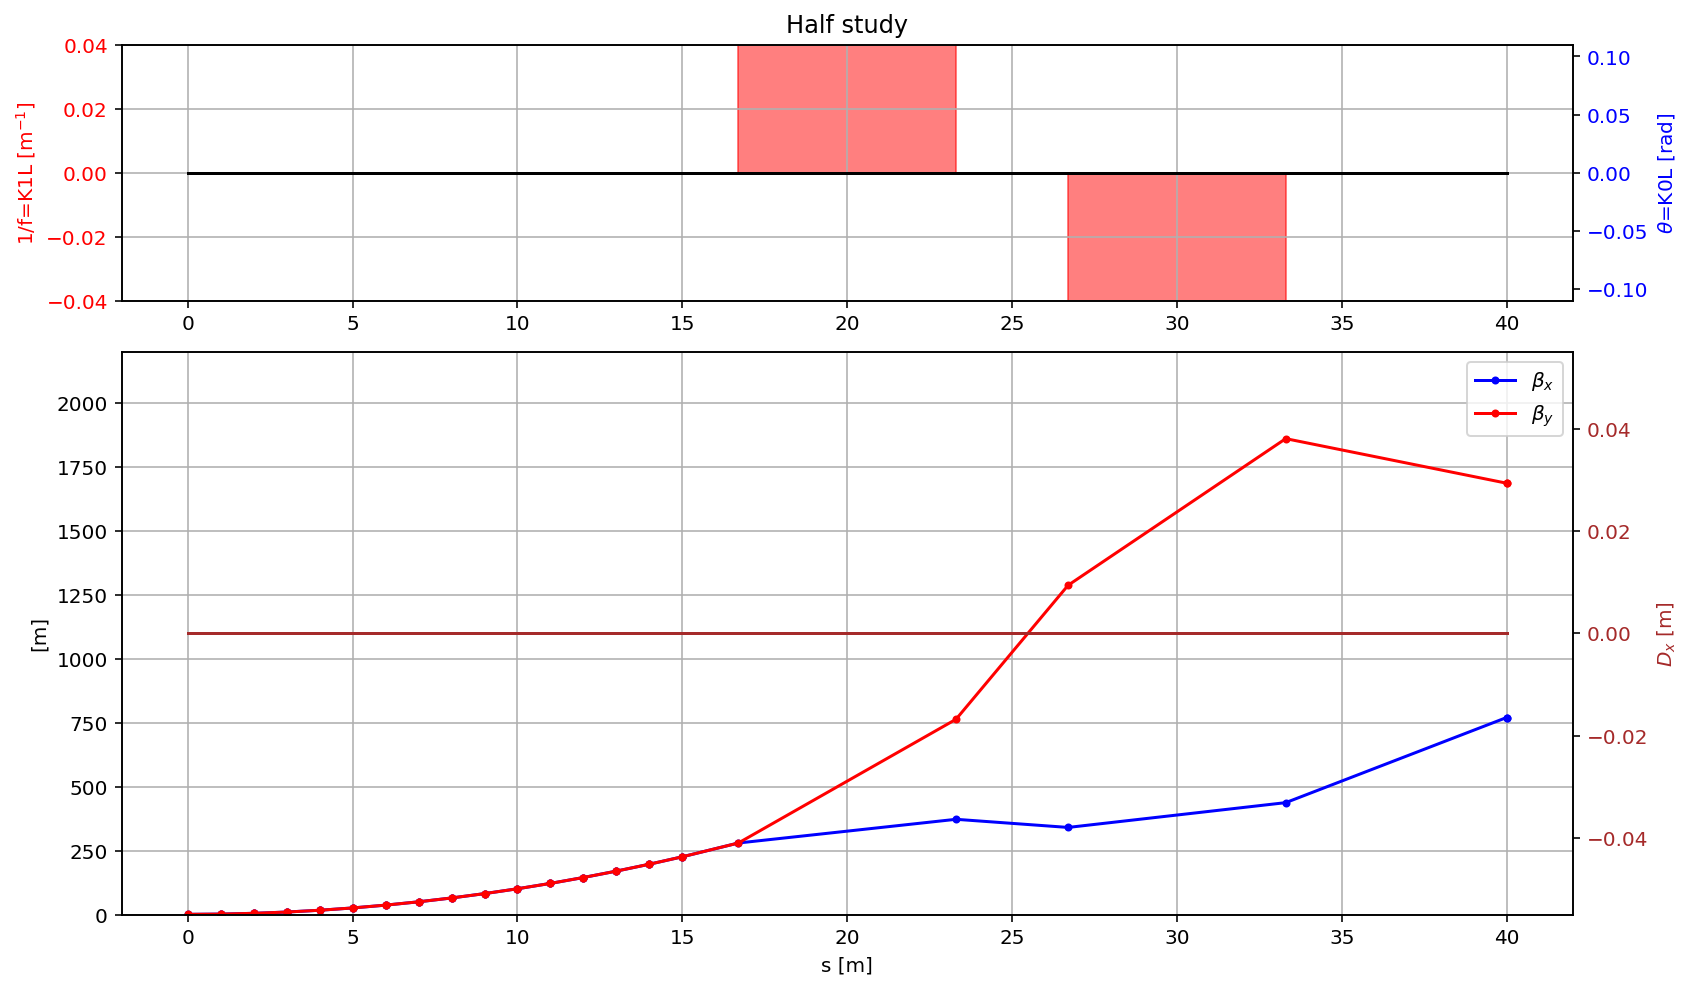

In [26]:
f(15, 6.60, 1)

### A symmetric doublet

In [27]:
myMad = Madx(stdout=False)
f=50
l_quad=1
dipole_angle=0
def f(f, l_quad, beta0):
    myString='''
    ! *********************************************************************
    ! Definition of parameters
    ! *********************************************************************
    option, rbarc=false;
    l_cell=40;
    quadrupoleLenght='''+format(l_quad) +''';
    f='''+format(f) +''';
    myK:=1/f/quadrupoleLenght;// m^-2
    
    ! *********************************************************************
    ! Definition of magnet
    ! ********************************************************************* 
    QF: quadrupole, L:=quadrupoleLenght, K1:=myK;
    QD: quadrupole, L:=quadrupoleLenght, K1:=-myK;


    ! *********************************************************************
    ! Definition of sequence
    ! *********************************************************************
    myHalfSS:sequence, refer=centre, L:=l_cell;
    m1: marker, at=1;
    m2: marker, at=2;
    m3: marker, at=3;
    m4: marker, at=4;
    m5: marker, at=5;
    m6: marker, at=6;
    m7: marker, at=7;
    m8: marker, at=8;
    m9: marker, at=9;
    m10: marker, at=10;
    m11: marker, at=11;
    m12: marker, at=12;
    m13: marker, at=13;
    m14: marker, at=14;
    m15: marker, at=15;
    quadrupole1: QF, at=l_cell/2;
    quadrupole2: QD, at=l_cell/4*3;
    endsequence;
    
    myFullSS:sequence, refer=centre, L:=l_cell*2;
    quadrupole2_l: QD, at=-l_cell/4*3+l_cell;
    quadrupole1_l: QF, at=-l_cell/2+l_cell;
    m15_l: marker, at=-15+l_cell;
    m14_l: marker, at=-14+l_cell;
    m13_l: marker, at=-13+l_cell;
    m12_l: marker, at=-12+l_cell;
    m11_l: marker, at=-11+l_cell;
    m10_l: marker, at=-10+l_cell;
    m9_l: marker, at=-9+l_cell;
    m8_l: marker, at=-8+l_cell;
    m7_l: marker, at=-7+l_cell;
    m6_l: marker, at=-6+l_cell;
    m5_l: marker, at=-5+l_cell;
    m4_l: marker, at=-4+l_cell;
    m3_l: marker, at=-3+l_cell;
    m2_l: marker, at=-2+l_cell;
    m1_l: marker, at=-1+l_cell;
    m1: marker, at=1+l_cell;
    m2: marker, at=2+l_cell;
    m3: marker, at=3+l_cell;
    m4: marker, at=4+l_cell;
    m5: marker, at=5+l_cell;
    m6: marker, at=6+l_cell;
    m7: marker, at=7+l_cell;
    m8: marker, at=8+l_cell;
    m9: marker, at=9+l_cell;
    m10: marker, at=10+l_cell;
    m11: marker, at=11+l_cell;
    m12: marker, at=12+l_cell;
    m13: marker, at=13+l_cell;
    m14: marker, at=14+l_cell;
    m15: marker, at=15+l_cell;
    quadrupole1: QF, at=l_cell/2+l_cell;
    quadrupole2: QD, at=l_cell/4*3+l_cell;
    endsequence;


    ! *********************************************************************
    ! Definition of beam
    ! *********************************************************************
    beam;

    ! *********************************************************************
    ! Use of the sequence
    ! *********************************************************************
    use, sequence=myHalfSS;

    ! *********************************************************************
    ! TWISS
    ! *********************************************************************
    SAVEBETA, LABEL=myBeta, PLACE=#e, SEQUENCE=myHalfSS;
    twiss, betx='''+format(beta0) +''',bety='''+format(beta0) +''';
    use, sequence=myFullSS;
    twiss, betx=myBeta->betx,bety=myBeta->bety,alfx=-myBeta->alfx,alfy=-myBeta->alfy;
    '''
    myMad.input(myString);

    myTwiss=myMad.table.twiss.dframe()

    # plotting the results
    fig = plt.figure(figsize=(13,8))
    # set up subplot grid
    #gridspec.GridSpec(3,3)

    ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
    plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


    DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')


    color = 'red'
    ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
    ax1.tick_params(axis='y', labelcolor=color)
    plt.grid()
    plt.ylim(-.04,.04)
    plt.title('Full insertion (doublet, symmetric)')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'blue'
    ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=color)


    #DF=myTwiss[(myTwiss['keyword']=='sbend')]
    #for i in range(len(DF)):
    #    aux=DF.iloc[i]
    #    plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle*1000/2, color='b')

    DF=myTwiss[(myTwiss['keyword']=='sbend')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.angle, v_offset=aux.angle/2, color='b')
    
    DF=myTwiss[(myTwiss['keyword']=='rbend')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.angle, v_offset=aux.angle/2, color='m')


    plt.ylim(-.11,.11)

    # large subplot
    plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

    plt.plot(myTwiss['s'],myTwiss['betx'],'b.-', label='$\\beta_x$')
    plt.plot(myTwiss['s'],myTwiss['bety'],'r.-', label='$\\beta_y$')
    plt.legend(loc='best')
    plt.ylabel('[m]')
    plt.xlabel('s [m]')
    plt.grid()
    plt.ylim(0,2200)

    ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
    plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$')
    ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
    ax3.tick_params(axis='y', labelcolor='brown')
    
    
interactive_plot = interactive(f, f=(10, 100, 1), l_quad=(0.1 ,10,.1),beta0=(1,2,.01),continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '550px'
interactive_plot

interactive(children=(IntSlider(value=55, description='f', min=10), FloatSlider(value=5.0, description='l_quad…

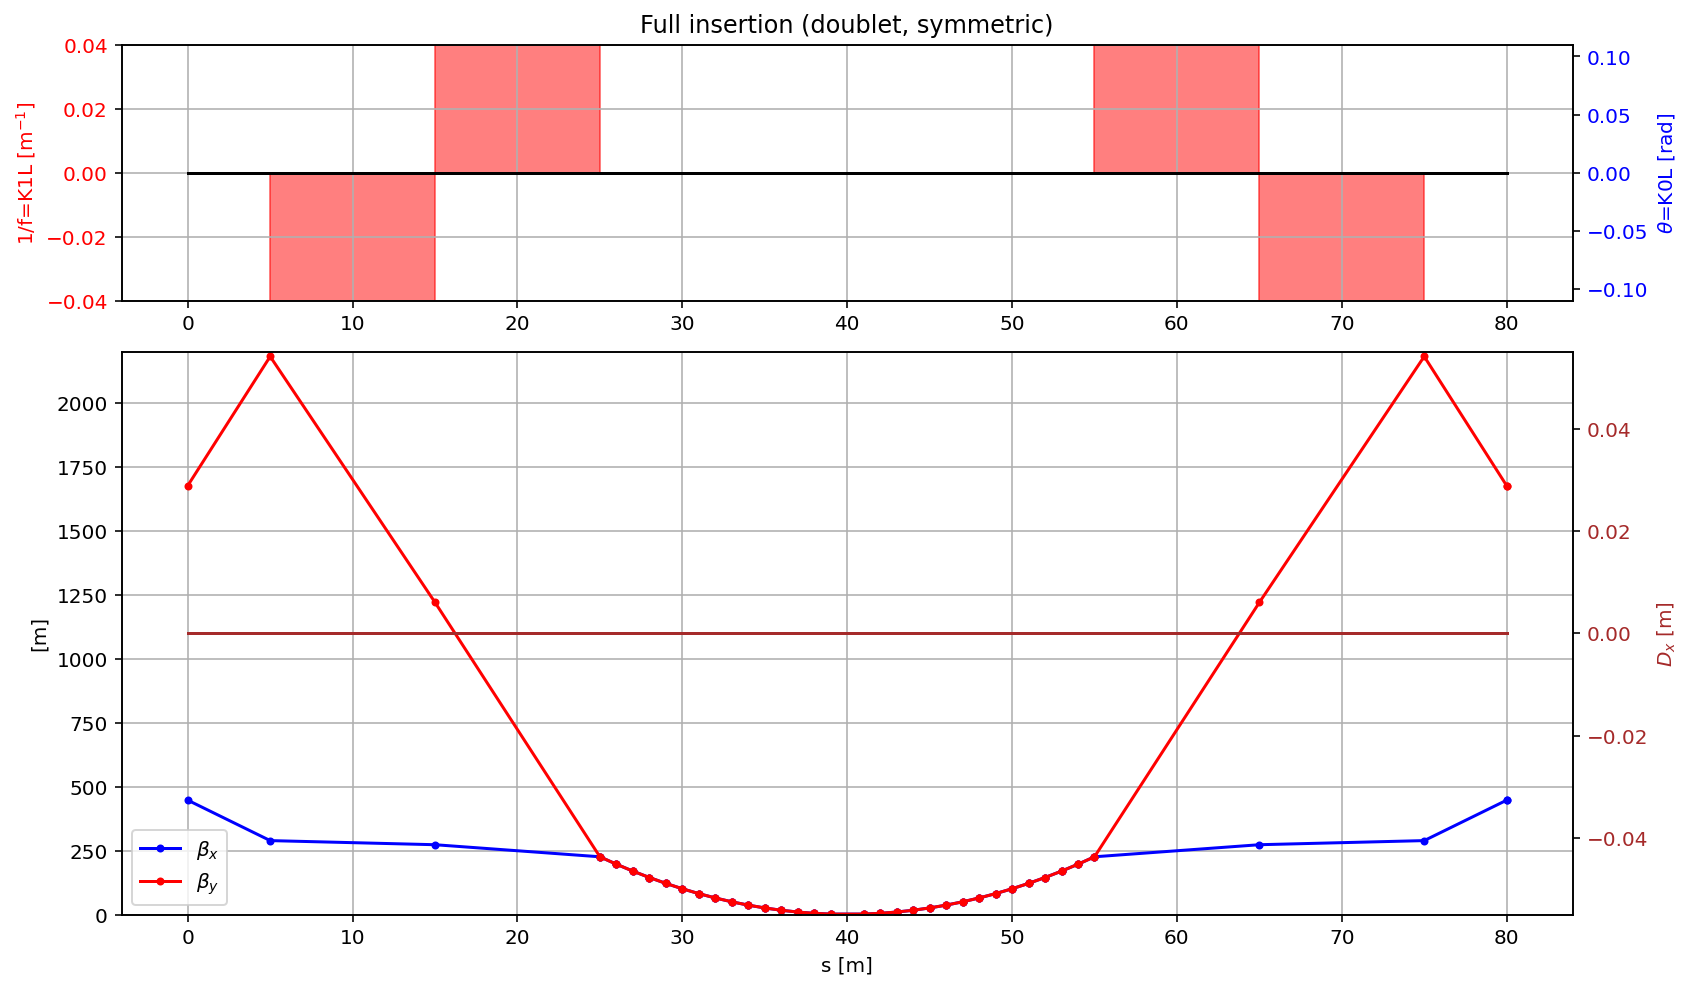

In [12]:
f(10, 10, 1)

### The anti-symmetric doublet

In [28]:
myMad = Madx(stdout=False)
f=50
l_quad=1
dipole_angle=0
def f(f, l_quad, beta0):
    myString='''
    ! *********************************************************************
    ! Definition of parameters
    ! *********************************************************************
    option, rbarc=false;
    l_cell=40;
    quadrupoleLenght='''+format(l_quad) +''';
    f='''+format(f) +''';
    myK:=1/f/quadrupoleLenght;// m^-2
    
    ! *********************************************************************
    ! Definition of magnet
    ! ********************************************************************* 
    QF: quadrupole, L:=quadrupoleLenght, K1:=myK;
    QD: quadrupole, L:=quadrupoleLenght, K1:=-myK;


    ! *********************************************************************
    ! Definition of sequence
    ! *********************************************************************
    myHalfSS:sequence, refer=centre, L:=l_cell;
    m1: marker, at=1;
    m2: marker, at=2;
    m3: marker, at=3;
    m4: marker, at=4;
    m5: marker, at=5;
    m6: marker, at=6;
    m7: marker, at=7;
    m8: marker, at=8;
    m9: marker, at=9;
    m10: marker, at=10;
    m11: marker, at=11;
    m12: marker, at=12;
    m13: marker, at=13;
    m14: marker, at=14;
    m15: marker, at=15;
    quadrupole1: QF, at=l_cell/2;
    quadrupole2: QD, at=l_cell/4*3;
    endsequence;
    
    myFullSS:sequence, refer=centre, L:=l_cell*2;
    quadrupole2_l: QF, at=-l_cell/4*3+l_cell;
    quadrupole1_l: QD, at=-l_cell/2+l_cell;
    m15_l: marker, at=-15+l_cell;
    m14_l: marker, at=-14+l_cell;
    m13_l: marker, at=-13+l_cell;
    m12_l: marker, at=-12+l_cell;
    m11_l: marker, at=-11+l_cell;
    m10_l: marker, at=-10+l_cell;
    m9_l: marker, at=-9+l_cell;
    m8_l: marker, at=-8+l_cell;
    m7_l: marker, at=-7+l_cell;
    m6_l: marker, at=-6+l_cell;
    m5_l: marker, at=-5+l_cell;
    m4_l: marker, at=-4+l_cell;
    m3_l: marker, at=-3+l_cell;
    m2_l: marker, at=-2+l_cell;
    m1_l: marker, at=-1+l_cell;
    m1: marker, at=1+l_cell;
    m2: marker, at=2+l_cell;
    m3: marker, at=3+l_cell;
    m4: marker, at=4+l_cell;
    m5: marker, at=5+l_cell;
    m6: marker, at=6+l_cell;
    m7: marker, at=7+l_cell;
    m8: marker, at=8+l_cell;
    m9: marker, at=9+l_cell;
    m10: marker, at=10+l_cell;
    m11: marker, at=11+l_cell;
    m12: marker, at=12+l_cell;
    m13: marker, at=13+l_cell;
    m14: marker, at=14+l_cell;
    m15: marker, at=15+l_cell;
    quadrupole1: QF, at=l_cell/2+l_cell;
    quadrupole2: QD, at=l_cell/4*3+l_cell;
    endsequence;


    ! *********************************************************************
    ! Definition of beam
    ! *********************************************************************
    beam;

    ! *********************************************************************
    ! Use of the sequence
    ! *********************************************************************
    use, sequence=myHalfSS;

    ! *********************************************************************
    ! TWISS
    ! *********************************************************************
    SAVEBETA, LABEL=myBeta, PLACE=#e, SEQUENCE=myHalfSS;
    twiss, betx='''+format(beta0) +''',bety='''+format(beta0) +''';
    use, sequence=myFullSS;
    twiss, betx=myBeta->bety,bety=myBeta->betx,alfx=-myBeta->alfy,alfy=-myBeta->alfx;
    '''
    myMad.input(myString);

    myTwiss=myMad.table.twiss.dframe()

    # plotting the results
    fig = plt.figure(figsize=(13,8))
    # set up subplot grid
    #gridspec.GridSpec(3,3)

    ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
    plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


    DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')


    color = 'red'
    ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
    ax1.tick_params(axis='y', labelcolor=color)
    plt.grid()
    plt.ylim(-.04,.04)
    plt.title('Full insertion (anti-symmetric)')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'blue'
    ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=color)


    #DF=myTwiss[(myTwiss['keyword']=='sbend')]
    #for i in range(len(DF)):
    #    aux=DF.iloc[i]
    #    plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle*1000/2, color='b')

    DF=myTwiss[(myTwiss['keyword']=='sbend')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.angle, v_offset=aux.angle/2, color='b')
    
    DF=myTwiss[(myTwiss['keyword']=='rbend')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.angle, v_offset=aux.angle/2, color='m')


    plt.ylim(-.11,.11)

    # large subplot
    plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

    plt.plot(myTwiss['s'],myTwiss['betx'],'b.-', label='$\\beta_x$')
    plt.plot(myTwiss['s'],myTwiss['bety'],'r.-', label='$\\beta_y$')
    plt.legend(loc='best')
    plt.ylabel('[m]')
    plt.xlabel('s [m]')
    plt.grid()
    plt.ylim(0,2200)

    ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
    plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$')
    ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
    ax3.tick_params(axis='y', labelcolor='brown')
    
    
interactive_plot = interactive(f, f=(10, 100, 1), l_quad=(0.1 ,10,.1),beta0=(1,2,.01),continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '550px'
interactive_plot

interactive(children=(IntSlider(value=55, description='f', min=10), FloatSlider(value=5.0, description='l_quad…

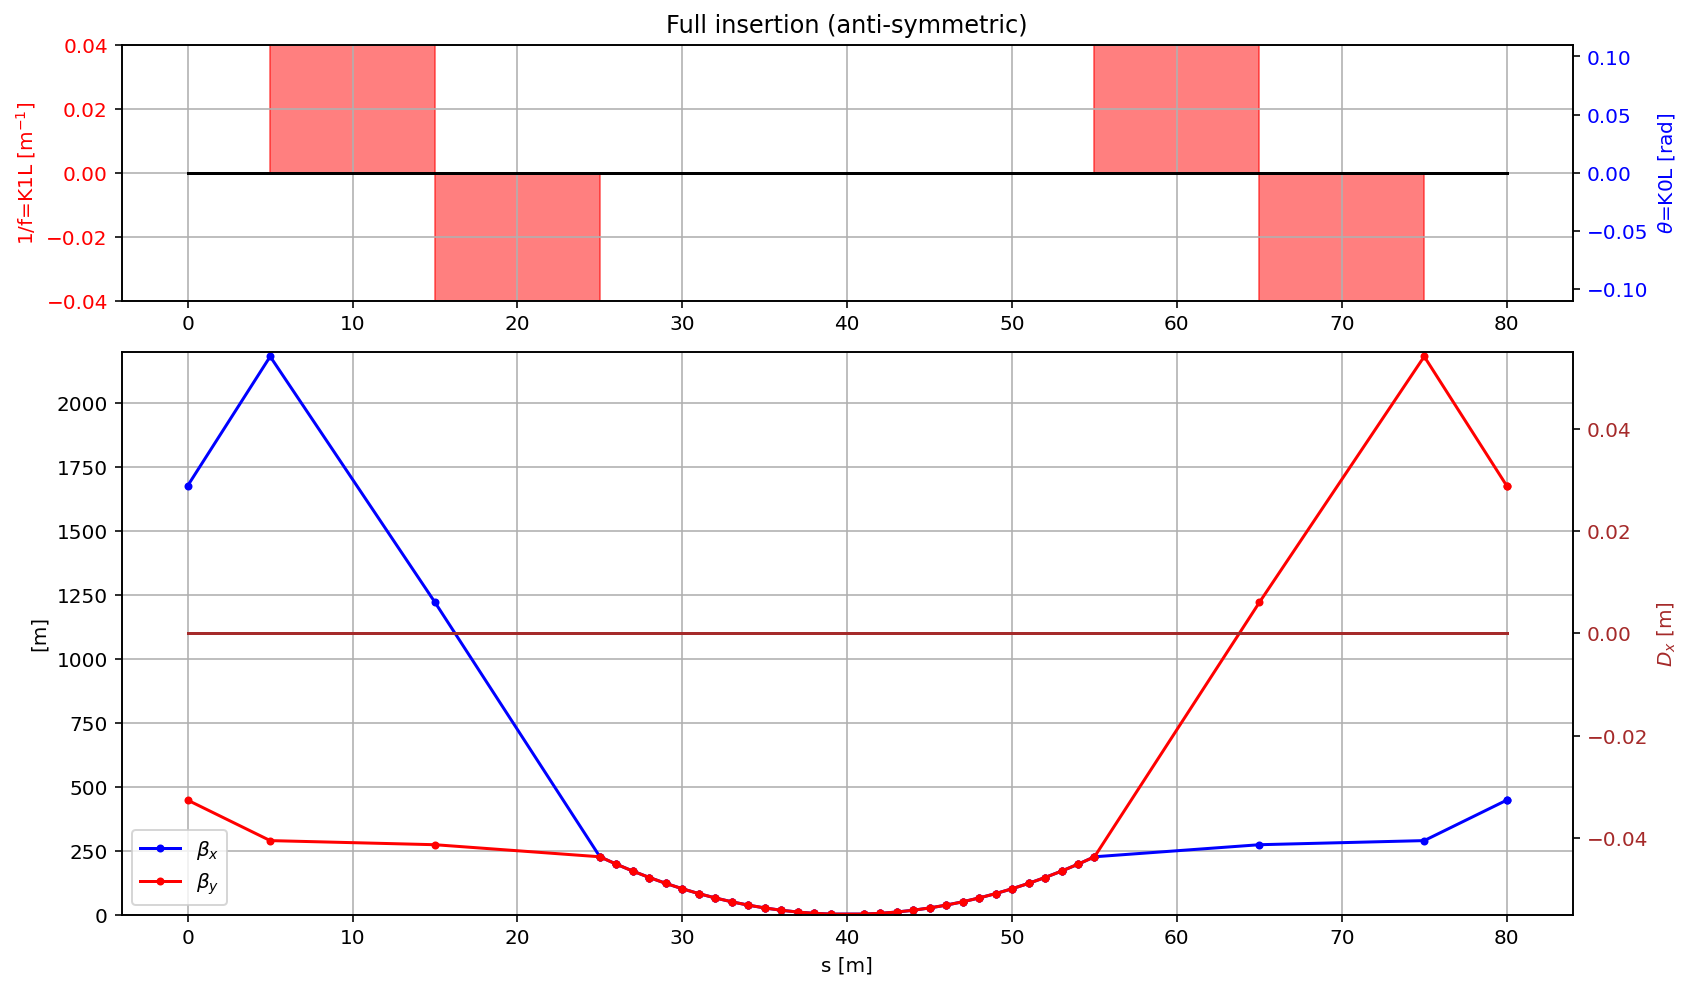

In [14]:
f(10, 10, 1)

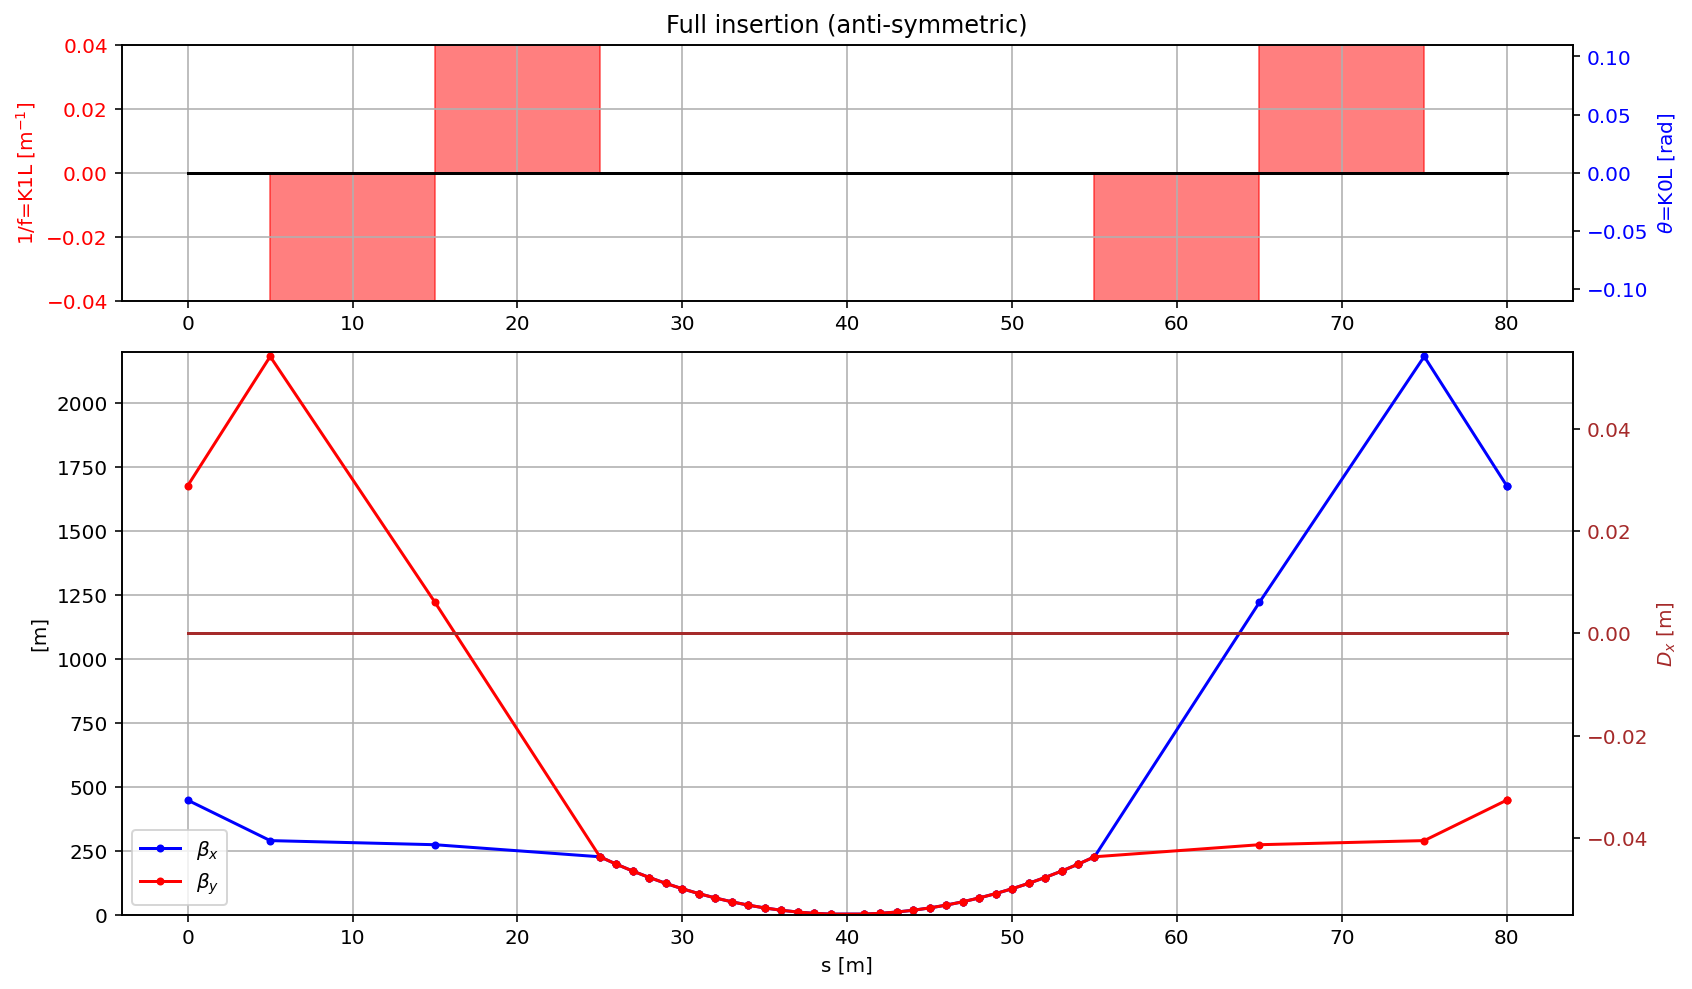

In [15]:
f(-10, 10, 1)

### From the doublet to triplet final focusing

In [29]:
myMad = Madx(stdout=False)
f=50
l_quad=1
dipole_angle=0
def f(f, l_quad, beta0):
    myString='''
    ! *********************************************************************
    ! Definition of parameters
    ! *********************************************************************
    option, rbarc=false;
    l_cell=60;
    quadrupoleLenght='''+format(l_quad) +''';
    f='''+format(f) +''';
    myK:=1/f/quadrupoleLenght;// m^-2
    
    ! *********************************************************************
    ! Definition of magnet
    ! ********************************************************************* 
    QF: quadrupole, L:=quadrupoleLenght, K1:=myK;
    QD: quadrupole, L:=quadrupoleLenght, K1:=-myK;


    ! *********************************************************************
    ! Definition of sequence
    ! *********************************************************************
    myHalfSS:sequence, refer=centre, L:=l_cell;
    m1: marker, at=1;
    m2: marker, at=2;
    m3: marker, at=3;
    m4: marker, at=4;
    m5: marker, at=5;
    m6: marker, at=6;
    m7: marker, at=7;
    m8: marker, at=8;
    m9: marker, at=9;
    m10: marker, at=10;
    m11: marker, at=11;
    m12: marker, at=12;
    m13: marker, at=13;
    m14: marker, at=14;
    m15: marker, at=15;
    quadrupole1: QF, at=40/2;
    quadrupole2a: QD, at=40/4*3;
    quadrupole2b: QD, at=40/4*4;
    quadrupole3: QF, at=40/4*5;
    
    m55: marker, at=55;
    m56: marker, at=56;
    m57: marker, at=57;
    m58: marker, at=58;
    m59: marker, at=59;

    endsequence;

    ! *********************************************************************
    ! Definition of beam
    ! *********************************************************************
    beam;

    ! *********************************************************************
    ! Use of the sequence
    ! *********************************************************************
    use, sequence=myHalfSS;

    ! *********************************************************************
    ! TWISS
    ! *********************************************************************
    twiss, betx='''+format(beta0) +''',bety='''+format(beta0) +''';
    '''
    myMad.input(myString);

    myTwiss=myMad.table.twiss.dframe()

    # plotting the results
    fig = plt.figure(figsize=(13,8))
    # set up subplot grid
    #gridspec.GridSpec(3,3)

    ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
    plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


    DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')


    color = 'red'
    ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
    ax1.tick_params(axis='y', labelcolor=color)
    plt.grid()
    plt.ylim(-.21,.21)
    plt.title('Half straight section (triplet)')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'blue'
    ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=color)


    #DF=myTwiss[(myTwiss['keyword']=='sbend')]
    #for i in range(len(DF)):
    #    aux=DF.iloc[i]
    #    plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle*1000/2, color='b')

    DF=myTwiss[(myTwiss['keyword']=='sbend')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.angle, v_offset=aux.angle/2, color='b')
    
    DF=myTwiss[(myTwiss['keyword']=='rbend')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.angle, v_offset=aux.angle/2, color='m')


    plt.ylim(-.11,.11)

    # large subplot
    plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

    plt.plot(myTwiss['s'],myTwiss['betx'],'b.-', label='$\\beta_x$')
    plt.plot(myTwiss['s'],myTwiss['bety'],'r.-', label='$\\beta_y$')
    plt.legend(loc='best')
    plt.ylabel('[m]')
    plt.xlabel('s [m]')
    plt.grid()
    plt.ylim(0,3000)

    ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
    plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$')
    ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
    ax3.tick_params(axis='y', labelcolor='brown')
    
    
interactive_plot = interactive(f, f=(5, 100, 1), l_quad=(0.1 ,10,.1),beta0=(1,2,.01),continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '550px'
interactive_plot

interactive(children=(IntSlider(value=52, description='f', min=5), FloatSlider(value=5.0, description='l_quad'…

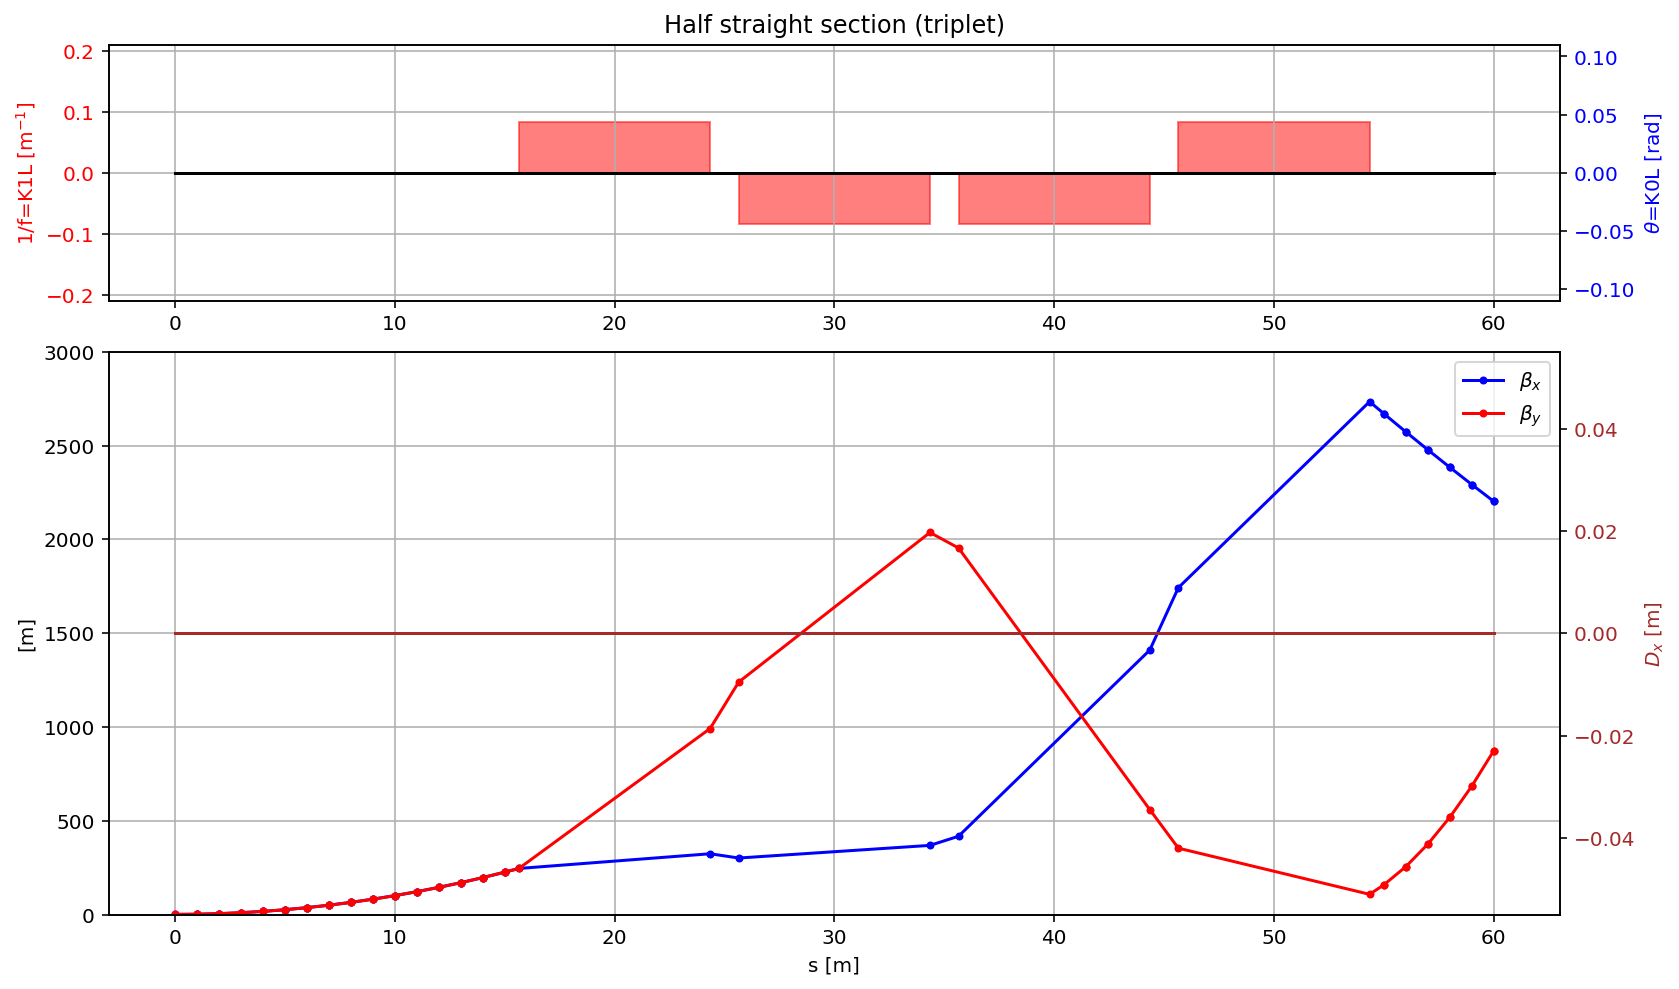

In [17]:
f(12, 8.7, 1)

### Symmetric triplets

In [30]:
myMad = Madx(stdout=False)
f=50
l_quad=1
dipole_angle=0
def f(f, l_quad, beta0):
    myString='''
    ! *********************************************************************
    ! Definition of parameters
    ! *********************************************************************
    option, rbarc=false;
    l_cell=60;
    quadrupoleLenght='''+format(l_quad) +''';
    f='''+format(f) +''';
    myK:=1/f/quadrupoleLenght;// m^-2
    
    ! *********************************************************************
    ! Definition of magnet
    ! ********************************************************************* 
    QF: quadrupole, L:=quadrupoleLenght, K1:=myK;
    QD: quadrupole, L:=quadrupoleLenght, K1:=-myK;


    ! *********************************************************************
    ! Definition of sequence
    ! *********************************************************************
    myHalfSS:sequence, refer=centre, L:=l_cell;
    m1: marker, at=1;
    m2: marker, at=2;
    m3: marker, at=3;
    m4: marker, at=4;
    m5: marker, at=5;
    m6: marker, at=6;
    m7: marker, at=7;
    m8: marker, at=8;
    m9: marker, at=9;
    m10: marker, at=10;
    m11: marker, at=11;
    m12: marker, at=12;
    m13: marker, at=13;
    m14: marker, at=14;
    m15: marker, at=15;
    quadrupole1: QF, at=40/2;
    quadrupole2a: QD, at=40/4*3;
    quadrupole2b: QD, at=40/4*4;
    quadrupole3: QF, at=40/4*5;
    m55: marker, at=55;
    m56: marker, at=56;
    m57: marker, at=57;
    m58: marker, at=58;
    m59: marker, at=59;
    endsequence;
    
    myFullSS:sequence, refer=centre, L:=l_cell*2;
    m59_l: marker, at=-59+l_cell;
    m58_l: marker, at=-58+l_cell;
    m57_l: marker, at=-57+l_cell;
    m56_l: marker, at=-56+l_cell;
    m55_l: marker, at=-55+l_cell;
    quadrupole3_l: QF, at=-40/4*5+l_cell;
    quadrupole2b_l: QD, at=-40/4*4+l_cell;
    quadrupole2a_l: QD, at=-40/4*3+l_cell;
    quadrupole1_l: QF, at=-40/2+l_cell;
    m15_l: marker, at=-15+l_cell;
    m14_l: marker, at=-14+l_cell;
    m13_l: marker, at=-13+l_cell;
    m12_l: marker, at=-12+l_cell;
    m11_l: marker, at=-11+l_cell;
    m10_l: marker, at=-10+l_cell;
    m9_l: marker, at=-9+l_cell;
    m8_l: marker, at=-8+l_cell;
    m7_l: marker, at=-7+l_cell;
    m6_l: marker, at=-6+l_cell;
    m5_l: marker, at=-5+l_cell;
    m4_l: marker, at=-4+l_cell;
    m3_l: marker, at=-3+l_cell;
    m2_l: marker, at=-2+l_cell;
    m1_l: marker, at=-1+l_cell;
    m1: marker, at=1+l_cell;
    m2: marker, at=2+l_cell;
    m3: marker, at=3+l_cell;
    m4: marker, at=4+l_cell;
    m5: marker, at=5+l_cell;
    m6: marker, at=6+l_cell;
    m7: marker, at=7+l_cell;
    m8: marker, at=8+l_cell;
    m9: marker, at=9+l_cell;
    m10: marker, at=10+l_cell;
    m11: marker, at=11+l_cell;
    m12: marker, at=12+l_cell;
    m13: marker, at=13+l_cell;
    m14: marker, at=14+l_cell;
    m15: marker, at=15+l_cell;
    quadrupole1: QF, at=40/2+l_cell;
    quadrupole2a: QD, at=40/4*3+l_cell;
    quadrupole2b: QD, at=40/4*4+l_cell;
    quadrupole3: QF, at=40/4*5+l_cell;
    m55: marker, at=55+l_cell;
    m56: marker, at=56+l_cell;
    m57: marker, at=57+l_cell;
    m58: marker, at=58+l_cell;
    m59: marker, at=59+l_cell;
    endsequence;

    ! *********************************************************************
    ! Definition of beam
    ! *********************************************************************
    beam;

    ! *********************************************************************
    ! Use of the sequence
    ! *********************************************************************
    use, sequence=myHalfSS;

    ! *********************************************************************
    ! TWISS
    ! *********************************************************************
    SAVEBETA, LABEL=myBeta, PLACE=#e, SEQUENCE=myHalfSS;
    twiss, betx='''+format(beta0) +''',bety='''+format(beta0) +''';
    
    use, sequence=myFullSS;
    twiss, betx=myBeta->betx,bety=myBeta->bety,alfx=-myBeta->alfx,alfy=-myBeta->alfy;
    '''
    myMad.input(myString);

    myTwiss=myMad.table.twiss.dframe()

    # plotting the results
    fig = plt.figure(figsize=(13,8))
    # set up subplot grid
    #gridspec.GridSpec(3,3)

    ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
    plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


    DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')


    color = 'red'
    ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
    ax1.tick_params(axis='y', labelcolor=color)
    plt.grid()
    plt.ylim(-.2,.2)
    plt.title('Full insertion (triplet, symmetric)')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'blue'
    ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=color)


    #DF=myTwiss[(myTwiss['keyword']=='sbend')]
    #for i in range(len(DF)):
    #    aux=DF.iloc[i]
    #    plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle*1000/2, color='b')

    DF=myTwiss[(myTwiss['keyword']=='sbend')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.angle, v_offset=aux.angle/2, color='b')
    
    DF=myTwiss[(myTwiss['keyword']=='rbend')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.angle, v_offset=aux.angle/2, color='m')


    plt.ylim(-.11,.11)

    # large subplot
    plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

    plt.plot(myTwiss['s'],myTwiss['betx'],'b.-', label='$\\beta_x$')
    plt.plot(myTwiss['s'],myTwiss['bety'],'r.-', label='$\\beta_y$')
    plt.legend(loc='best')
    plt.ylabel('[m]')
    plt.xlabel('s [m]')
    plt.grid()
    plt.ylim(0,3000)

    ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
    plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$')
    ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
    ax3.tick_params(axis='y', labelcolor='brown')
    
    
interactive_plot = interactive(f, f=(10, 100, 1), l_quad=(0.1 ,10,.1),beta0=(1,2,.01),continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '550px'
interactive_plot

interactive(children=(IntSlider(value=55, description='f', min=10), FloatSlider(value=5.0, description='l_quad…

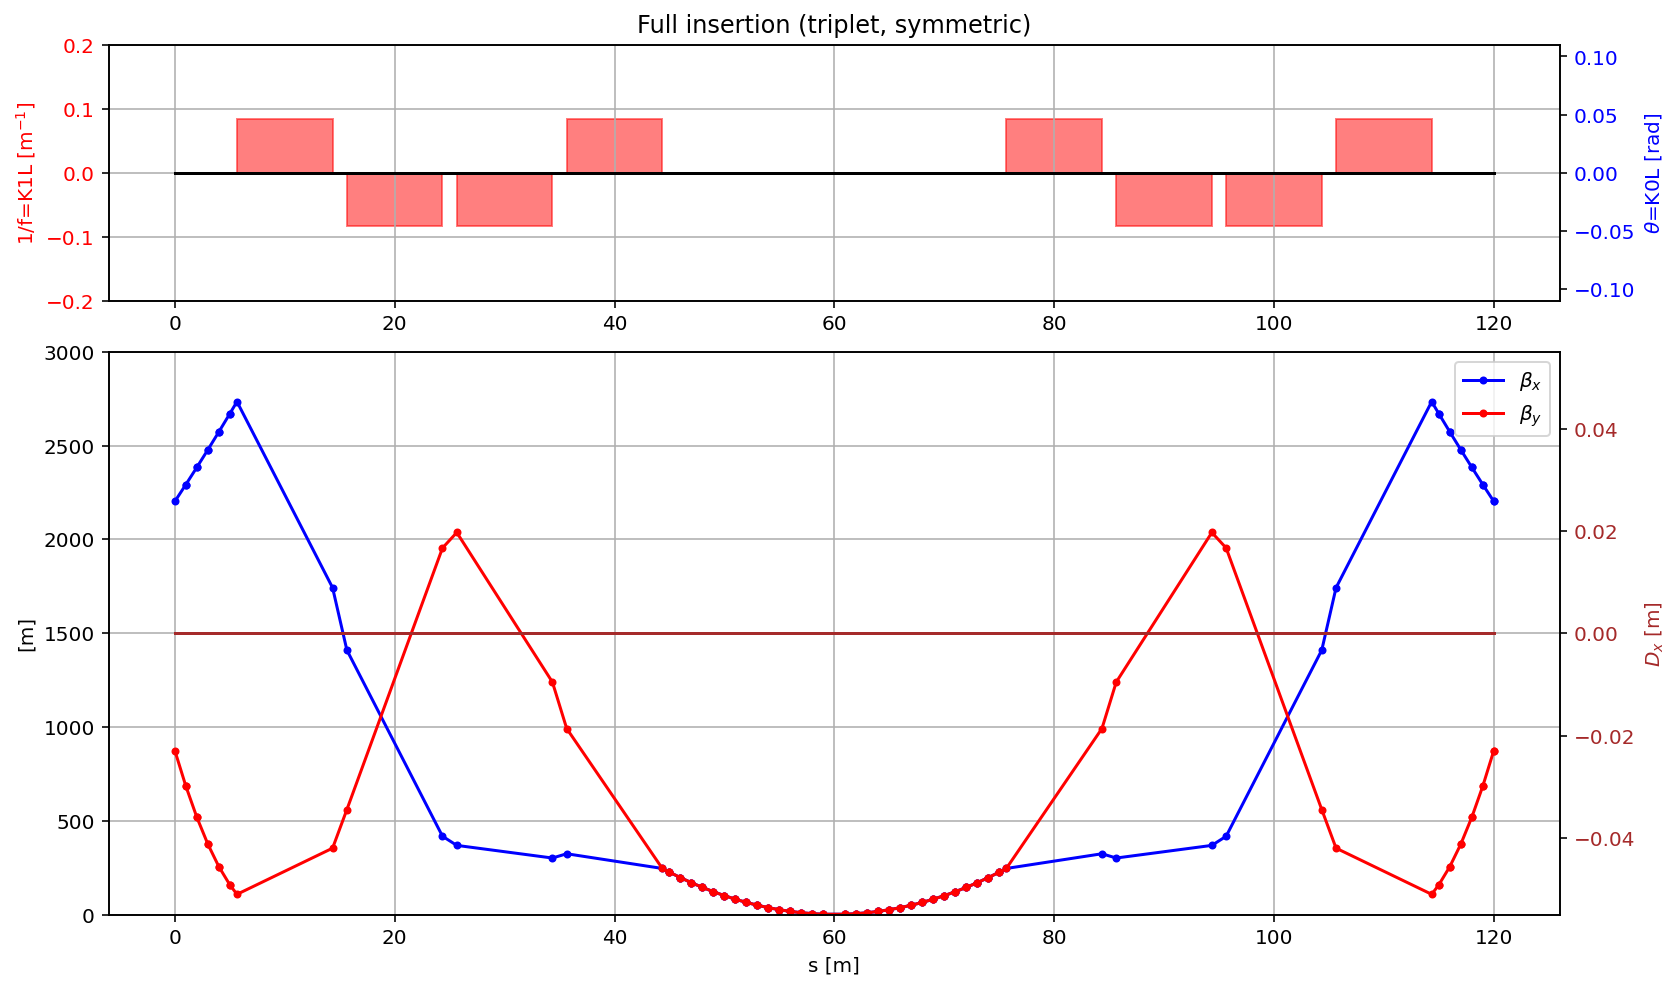

In [13]:
f(12, 8.7, 1)

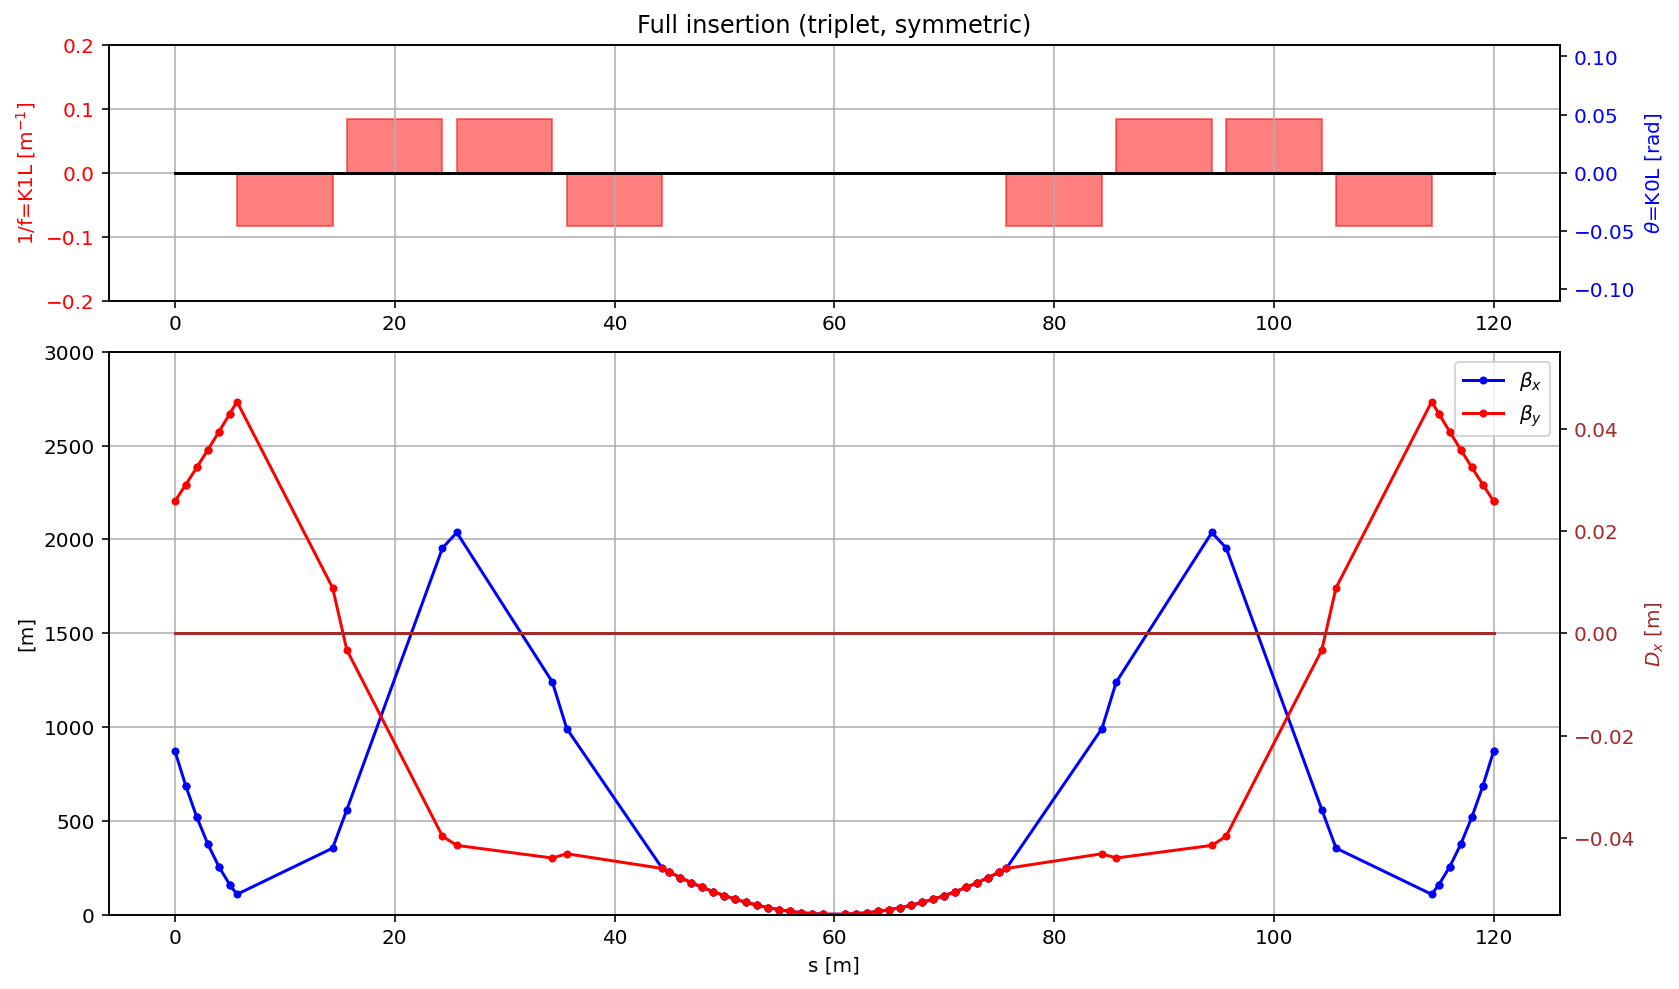

In [14]:
f(-12, 8.7, 1)

### Anti-symmetric triplet

In [31]:
myMad = Madx(stdout=False)
f=50
l_quad=1
dipole_angle=0
def f(f, l_quad, beta0):
    myString='''
    ! *********************************************************************
    ! Definition of parameters
    ! *********************************************************************
    option, rbarc=false;
    l_cell=60;
    quadrupoleLenght='''+format(l_quad) +''';
    f='''+format(f) +''';
    myK:=1/f/quadrupoleLenght;// m^-2
    
    ! *********************************************************************
    ! Definition of magnet
    ! ********************************************************************* 
    QF: quadrupole, L:=quadrupoleLenght, K1:=myK;
    QD: quadrupole, L:=quadrupoleLenght, K1:=-myK;


    ! *********************************************************************
    ! Definition of sequence
    ! *********************************************************************
    myHalfSS:sequence, refer=centre, L:=l_cell;
    m1: marker, at=1;
    m2: marker, at=2;
    m3: marker, at=3;
    m4: marker, at=4;
    m5: marker, at=5;
    m6: marker, at=6;
    m7: marker, at=7;
    m8: marker, at=8;
    m9: marker, at=9;
    m10: marker, at=10;
    m11: marker, at=11;
    m12: marker, at=12;
    m13: marker, at=13;
    m14: marker, at=14;
    m15: marker, at=15;
    quadrupole1: QF, at=40/2;
    quadrupole2a: QD, at=40/4*3;
    quadrupole2b: QD, at=40/4*4;
    quadrupole3: QF, at=40/4*5;
    m55: marker, at=55;
    m56: marker, at=56;
    m57: marker, at=57;
    m58: marker, at=58;
    m59: marker, at=59;
    endsequence;
    
    myFullSS:sequence, refer=centre, L:=l_cell*2;
    m59_l: marker, at=-59+l_cell;
    m58_l: marker, at=-58+l_cell;
    m57_l: marker, at=-57+l_cell;
    m56_l: marker, at=-56+l_cell;
    m55_l: marker, at=-55+l_cell;
    quadrupole3_l: QD, at=-40/4*5+l_cell;
    quadrupole2b_l: QF, at=-40/4*4+l_cell;
    quadrupole2a_l: QF, at=-40/4*3+l_cell;
    quadrupole1_l: QD, at=-40/2+l_cell;
    m15_l: marker, at=-15+l_cell;
    m14_l: marker, at=-14+l_cell;
    m13_l: marker, at=-13+l_cell;
    m12_l: marker, at=-12+l_cell;
    m11_l: marker, at=-11+l_cell;
    m10_l: marker, at=-10+l_cell;
    m9_l: marker, at=-9+l_cell;
    m8_l: marker, at=-8+l_cell;
    m7_l: marker, at=-7+l_cell;
    m6_l: marker, at=-6+l_cell;
    m5_l: marker, at=-5+l_cell;
    m4_l: marker, at=-4+l_cell;
    m3_l: marker, at=-3+l_cell;
    m2_l: marker, at=-2+l_cell;
    m1_l: marker, at=-1+l_cell;
    m1: marker, at=1+l_cell;
    m2: marker, at=2+l_cell;
    m3: marker, at=3+l_cell;
    m4: marker, at=4+l_cell;
    m5: marker, at=5+l_cell;
    m6: marker, at=6+l_cell;
    m7: marker, at=7+l_cell;
    m8: marker, at=8+l_cell;
    m9: marker, at=9+l_cell;
    m10: marker, at=10+l_cell;
    m11: marker, at=11+l_cell;
    m12: marker, at=12+l_cell;
    m13: marker, at=13+l_cell;
    m14: marker, at=14+l_cell;
    m15: marker, at=15+l_cell;
    quadrupole1: QF, at=40/2+l_cell;
    quadrupole2a: QD, at=40/4*3+l_cell;
    quadrupole2b: QD, at=40/4*4+l_cell;
    quadrupole3: QF, at=40/4*5+l_cell;
    m55: marker, at=55+l_cell;
    m56: marker, at=56+l_cell;
    m57: marker, at=57+l_cell;
    m58: marker, at=58+l_cell;
    m59: marker, at=59+l_cell;
    endsequence;

    ! *********************************************************************
    ! Definition of beam
    ! *********************************************************************
    beam;

    ! *********************************************************************
    ! Use of the sequence
    ! *********************************************************************
    use, sequence=myHalfSS;

    ! *********************************************************************
    ! TWISS
    ! *********************************************************************
    SAVEBETA, LABEL=myBeta, PLACE=#e, SEQUENCE=myHalfSS;
    twiss, betx='''+format(beta0) +''',bety='''+format(beta0) +''';
    
    use, sequence=myFullSS;
    twiss, betx=myBeta->bety,bety=myBeta->betx,alfx=-myBeta->alfy,alfy=-myBeta->alfx;
    '''
    myMad.input(myString);

    myTwiss=myMad.table.twiss.dframe()

    # plotting the results
    fig = plt.figure(figsize=(13,8))
    # set up subplot grid
    #gridspec.GridSpec(3,3)

    ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
    plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


    DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')


    color = 'red'
    ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
    ax1.tick_params(axis='y', labelcolor=color)
    plt.grid()
    plt.ylim(-.2,.2)
    plt.title('Full insertion (triplet, anti-symmetric)')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'blue'
    ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=color)


    #DF=myTwiss[(myTwiss['keyword']=='sbend')]
    #for i in range(len(DF)):
    #    aux=DF.iloc[i]
    #    plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle*1000/2, color='b')

    DF=myTwiss[(myTwiss['keyword']=='sbend')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.angle, v_offset=aux.angle/2, color='b')
    
    DF=myTwiss[(myTwiss['keyword']=='rbend')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.angle, v_offset=aux.angle/2, color='m')


    plt.ylim(-.11,.11)

    # large subplot
    plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

    plt.plot(myTwiss['s'],myTwiss['betx'],'b.-', label='$\\beta_x$')
    plt.plot(myTwiss['s'],myTwiss['bety'],'r.-', label='$\\beta_y$')
    plt.legend(loc='best')
    plt.ylabel('[m]')
    plt.xlabel('s [m]')
    plt.grid()
    plt.ylim(0,3000)

    ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
    plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$')
    ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
    ax3.tick_params(axis='y', labelcolor='brown')
    
    
interactive_plot = interactive(f, f=(10, 100, 1), l_quad=(0.1 ,10,.1),beta0=(1,10,.01),continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '550px'
interactive_plot

interactive(children=(IntSlider(value=55, description='f', min=10), FloatSlider(value=5.0, description='l_quad…

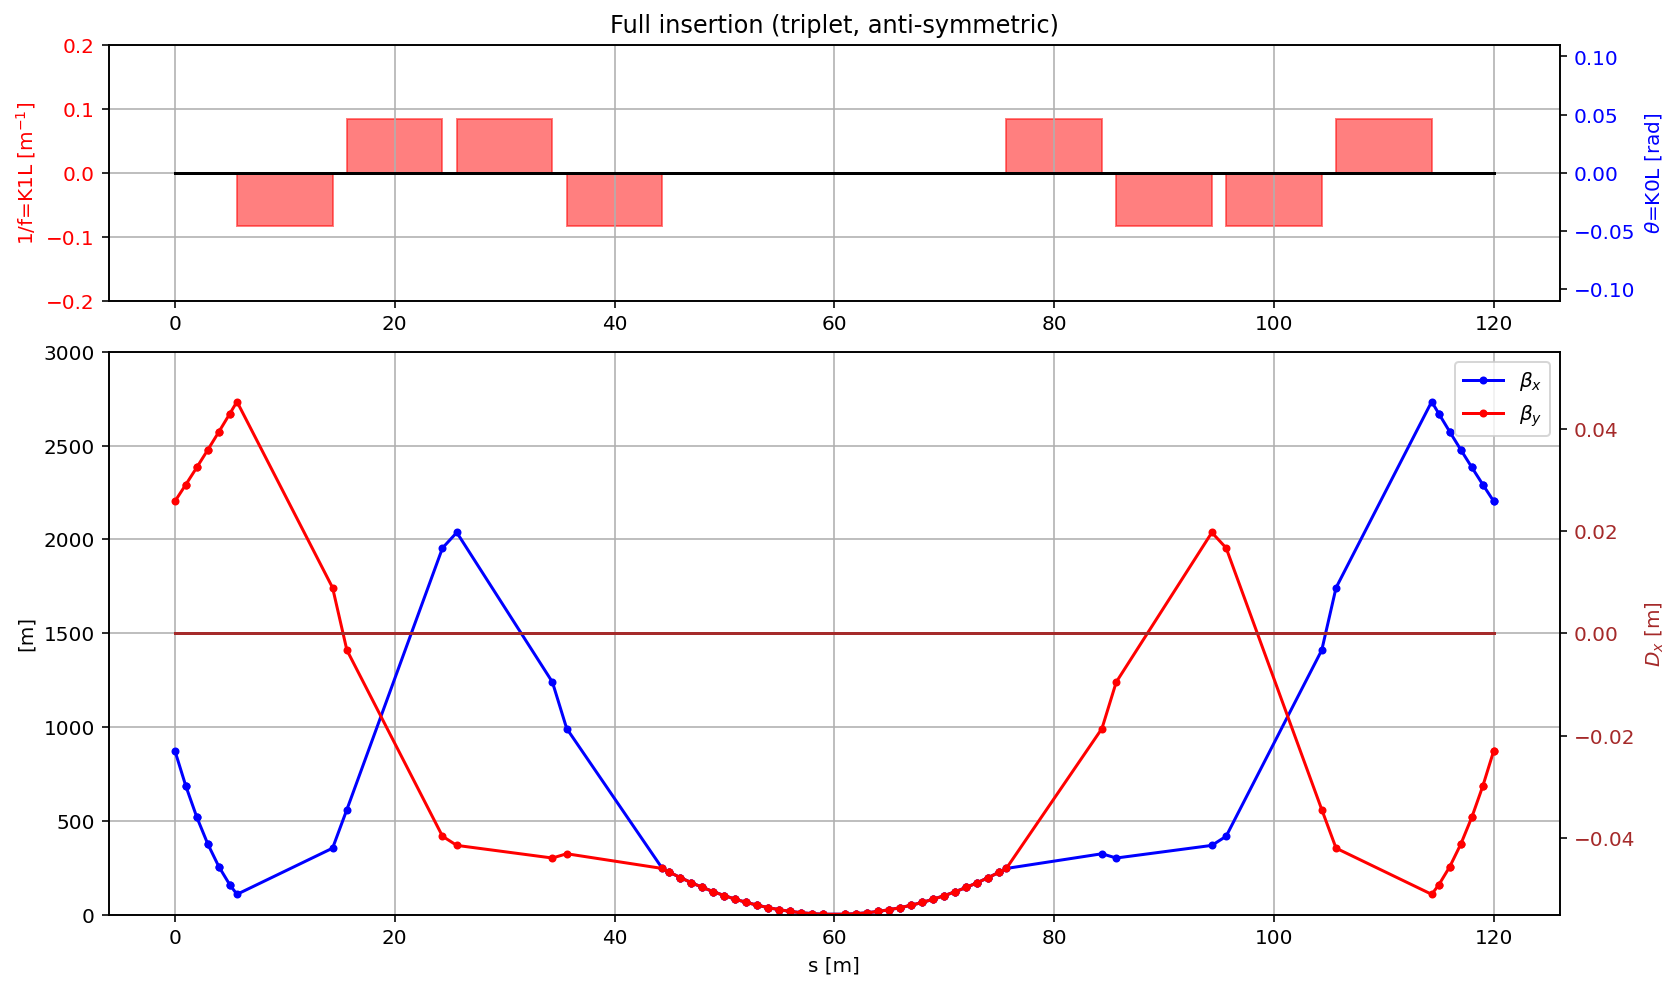

In [18]:
f(12, 8.7, 1)


  Number of warnings: 24
24 in C and 0 in Fortran

  ++++++++++++++++++++++++++++++++++++++++++++
  +          MAD-X finished normally         +
  ++++++++++++++++++++++++++++++++++++++++++++


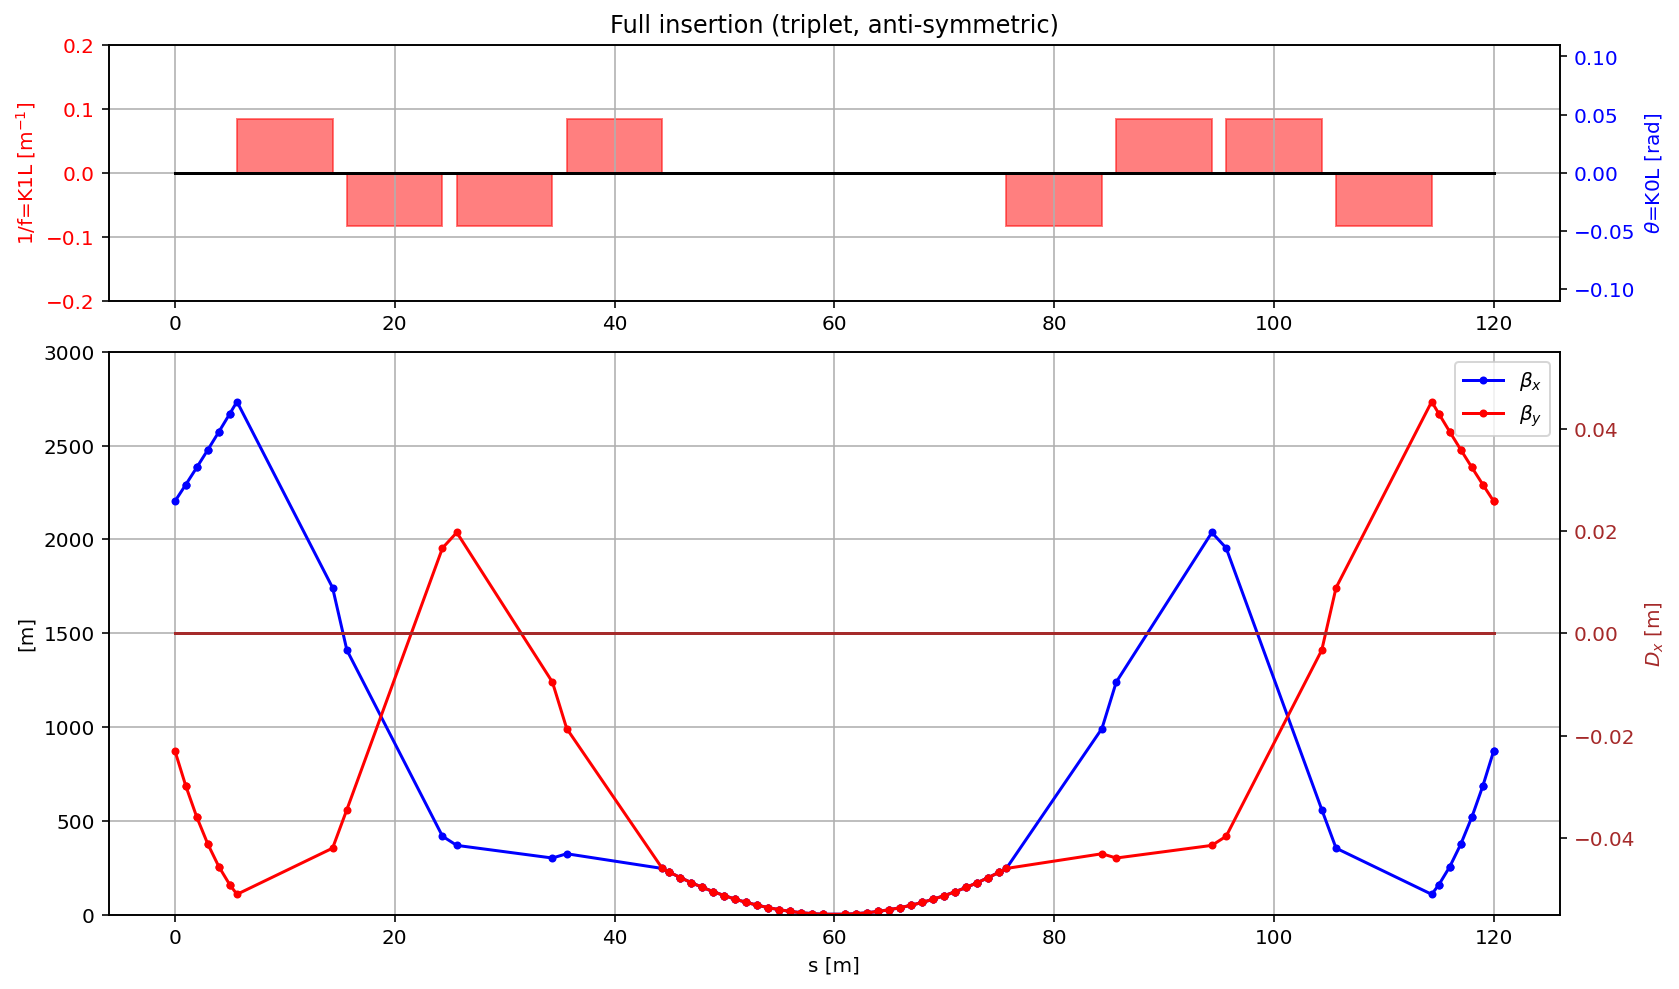

In [19]:
f(-12, 8.7, 1)

# Telescopic squeeze

By controlling the $\beta$-function at the entrance of the triplet one can adjust the $\beta$-function at s=0 without trimming the final focusing quadrupoles: this is the so-called telescopic squeeze.

In [20]:
myMad = Madx(stdout=False)
f=50
l_quad=1
dipole_angle=0
def f(f=14, l_quad=3.20, beta0=1):
    myString='''
    ! *********************************************************************
    ! Definition of parameters
    ! *********************************************************************
    option, rbarc=false;
    l_cell=60;
    quadrupoleLenght='''+format(l_quad) +''';
    f='''+format(f) +''';
    myK:=1/f/quadrupoleLenght;// m^-2
    
    ! *********************************************************************
    ! Definition of magnet
    ! ********************************************************************* 
    QF: quadrupole, L:=quadrupoleLenght, K1:=myK;
    QD: quadrupole, L:=quadrupoleLenght, K1:=-myK;


    ! *********************************************************************
    ! Definition of sequence
    ! *********************************************************************
    myHalfSS:sequence, refer=centre, L:=l_cell;
    m1: marker, at=1;
    m2: marker, at=2;
    m3: marker, at=3;
    m4: marker, at=4;
    m5: marker, at=5;
    m6: marker, at=6;
    m7: marker, at=7;
    m8: marker, at=8;
    m9: marker, at=9;
    m10: marker, at=10;
    m11: marker, at=11;
    m12: marker, at=12;
    m13: marker, at=13;
    m14: marker, at=14;
    m15: marker, at=15;
    quadrupole1: QF, at=40/2;
    quadrupole2a: QD, at=40/4*3;
    quadrupole2b: QD, at=40/4*4;
    quadrupole3: QF, at=40/4*5;
    m55: marker, at=55;
    m56: marker, at=56;
    m57: marker, at=57;
    m58: marker, at=58;
    m59: marker, at=59;
    endsequence;
    
    myFullSS:sequence, refer=centre, L:=l_cell*2;
    m59_l: marker, at=-59+l_cell;
    m58_l: marker, at=-58+l_cell;
    m57_l: marker, at=-57+l_cell;
    m56_l: marker, at=-56+l_cell;
    m55_l: marker, at=-55+l_cell;
    quadrupole3_l: QD, at=-40/4*5+l_cell;
    quadrupole2b_l: QF, at=-40/4*4+l_cell;
    quadrupole2a_l: QF, at=-40/4*3+l_cell;
    quadrupole1_l: QD, at=-40/2+l_cell;
    m15_l: marker, at=-15+l_cell;
    m14_l: marker, at=-14+l_cell;
    m13_l: marker, at=-13+l_cell;
    m12_l: marker, at=-12+l_cell;
    m11_l: marker, at=-11+l_cell;
    m10_l: marker, at=-10+l_cell;
    m9_l: marker, at=-9+l_cell;
    m8_l: marker, at=-8+l_cell;
    m7_l: marker, at=-7+l_cell;
    m6_l: marker, at=-6+l_cell;
    m5_l: marker, at=-5+l_cell;
    m4_l: marker, at=-4+l_cell;
    m3_l: marker, at=-3+l_cell;
    m2_l: marker, at=-2+l_cell;
    m1_l: marker, at=-1+l_cell;
    m1: marker, at=1+l_cell;
    m2: marker, at=2+l_cell;
    m3: marker, at=3+l_cell;
    m4: marker, at=4+l_cell;
    m5: marker, at=5+l_cell;
    m6: marker, at=6+l_cell;
    m7: marker, at=7+l_cell;
    m8: marker, at=8+l_cell;
    m9: marker, at=9+l_cell;
    m10: marker, at=10+l_cell;
    m11: marker, at=11+l_cell;
    m12: marker, at=12+l_cell;
    m13: marker, at=13+l_cell;
    m14: marker, at=14+l_cell;
    m15: marker, at=15+l_cell;
    quadrupole1: QF, at=40/2+l_cell;
    quadrupole2a: QD, at=40/4*3+l_cell;
    quadrupole2b: QD, at=40/4*4+l_cell;
    quadrupole3: QF, at=40/4*5+l_cell;
    m55: marker, at=55+l_cell;
    m56: marker, at=56+l_cell;
    m57: marker, at=57+l_cell;
    m58: marker, at=58+l_cell;
    m59: marker, at=59+l_cell;
    endsequence;

    ! *********************************************************************
    ! Definition of beam
    ! *********************************************************************
    beam;

    ! *********************************************************************
    ! Use of the sequence
    ! *********************************************************************
    use, sequence=myHalfSS;

    ! *********************************************************************
    ! TWISS
    ! *********************************************************************
    SAVEBETA, LABEL=myBeta, PLACE=#e, SEQUENCE=myHalfSS;
    twiss, betx='''+format(beta0) +''',bety='''+format(beta0) +''';
    
    use, sequence=myFullSS;
    twiss, betx=myBeta->bety,bety=myBeta->betx,alfx=-myBeta->alfy,alfy=-myBeta->alfx;
    '''
    myMad.input(myString);
    return myMad.table.twiss.dframe()

betx=[]
bety=[]
alfx=[]
alfy=[]

for i in np.arange(1,11,1):
    aux=f(f=14, l_quad=3.20, beta0=i).iloc[0]
    betx.append(aux['betx'])
    bety.append(aux['bety'])
    alfx.append(aux['alfx'])
    alfy.append(aux['alfy'])

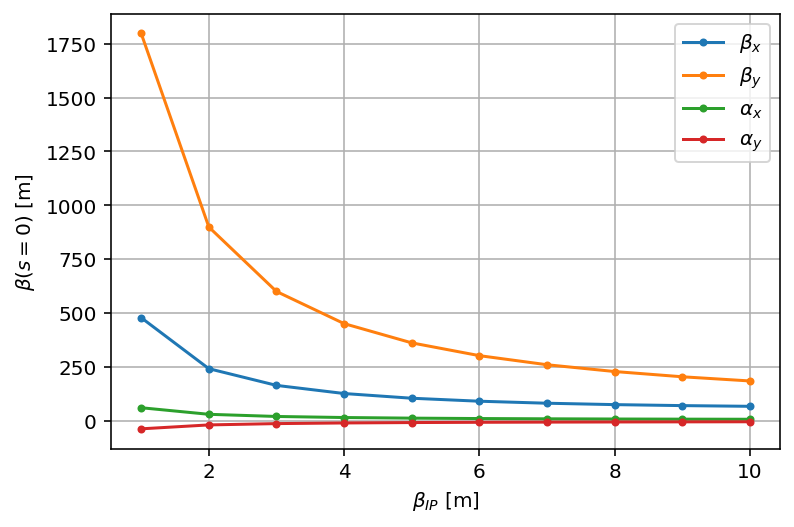

In [21]:
beta0=np.arange(1,11,1)
plt.plot(beta0,betx,'.-',label='$\\beta_x$')
plt.plot(beta0,bety,'.-',label='$\\beta_y$')
plt.plot(beta0,alfx,'.-',label='$\\alpha_x$')
plt.plot(beta0,alfy,'.-',label='$\\alpha_y$')
plt.grid()
plt.xlabel('$\\beta_{IP}$ [m]')
plt.ylabel('$\\beta(s=0)$ [m]')
plt.legend(loc='best')